In [ ]:
### dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import nltk
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
# nltk.download('stopwords')
warnings.filterwarnings("ignore", category=DeprecationWarning) 
%matplotlib inline
sns.set()

In [ ]:
### import dataset

In [2]:
targetset = pd.read_csv('output/hotel_review_data.csv')
len(targetset)

10000

In [ ]:
###There are cities named the same in multiple states. Need to combine to make unique.

In [3]:
targetset["city_and_state"] = targetset["city"] + ", " + targetset["province"]

In [ ]:
### checking how many reviews are associated with which cities. Machine learning will not work if there isn't enough data.

In [4]:
targetset["city_and_state"].value_counts()

San Diego, CA        1189
San Francisco, CA     808
New Orleans, LA       798
Atlanta, GA           762
Orlando, FL           734
                     ... 
Bardstown, KY           1
Pleasanton, TX          1
Carrollton, VA          1
Youngstown, NY          1
Two Rivers, WI          1
Name: city_and_state, Length: 893, dtype: int64

In [ ]:
### curating out low review counts

In [5]:
cutoff = targetset.groupby("city_and_state").filter(lambda x:len(x)>10)
len(cutoff)
cutoff["city"].value_counts()

San Diego          1189
San Francisco       808
New Orleans         798
Atlanta             762
Orlando             734
                   ... 
Gatlinburg           11
King of Prussia      11
Tulsa                11
Santa Monica         11
Arlington            11
Name: city, Length: 64, dtype: int64

In [6]:
cutoff.head()

,id,address,city,country,latitude,longitude,name,postalCode,province,reviews_rating,reviews_sourceURLs,reviews_text,reviews_title,city_and_state
5,6,167 W Main St,Lexington,US,38.047014,-84.497742,21c Museum Hotel Lexington,40507,KY,4,http://www.tripadvisor.com/Hotel_Review-g39588...,"This is such a fun, lovely hotel. The attentio...",Loved staying here,"Lexington, KY"
6,7,167 W Main St,Lexington,US,38.047014,-84.497742,21c Museum Hotel Lexington,40507,KY,1,https://www.tripadvisor.com/Hotel_Review-g3958...,We recently stayed at this hotel on a trip to ...,Does not live up to its reputation,"Lexington, KY"
8,9,2240 Buena Vista Rd,Lexington,US,38.042100,-84.427100,Microtel Inn Suites By Wyndham Lexington,40505,KY,5,https://www.tripadvisor.co.uk/Hotel_Review-g39...,MoreMore,Location Location Location,"Lexington, KY"
10,11,1953 Nicholasville Rd,Lexington,US,38.012430,-84.516350,Hampton Inn Lexington Medical Center,40503,KY,5,https://www.tripadvisor.com/Hotel_Review-g3958...,This is a new Hampton Inn and is well decorate...,Beautiful hotel,"Lexington, KY"
13,14,610 Poydras St,New Orleans,US,29.949125,-90.069748,The Whitney Hotel,70130,LA,3,https://www.tripadvisor.com/Hotel_Review-g6086...,The water is very hot and there's no cold wate...,"Very hot water, bad food","New Orleans, LA"


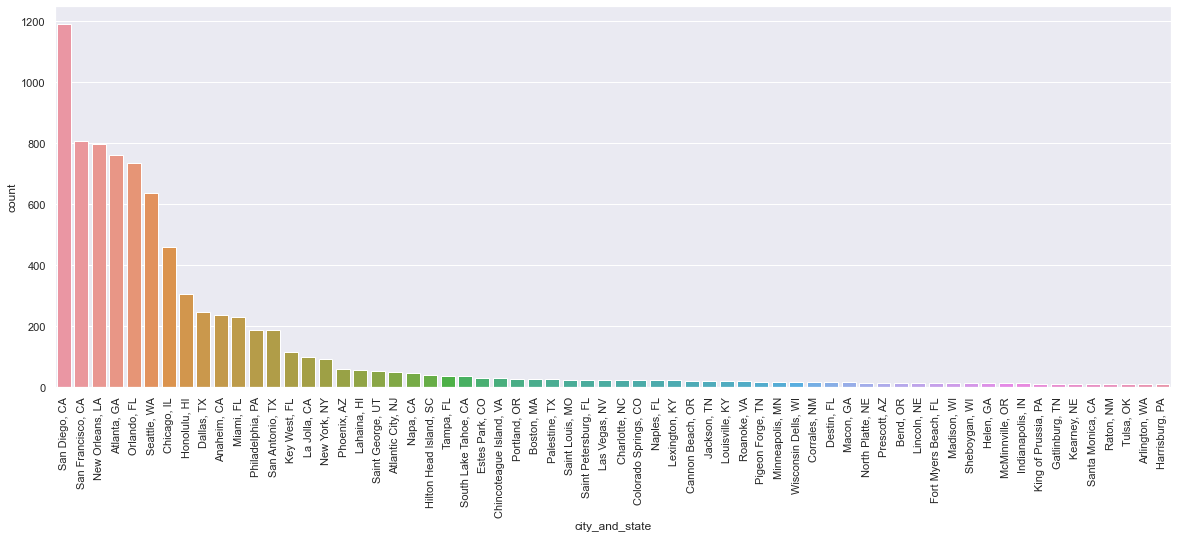

In [7]:
xaxis = cutoff.city_and_state.value_counts().index.tolist()
fig1 = plt.subplots(figsize = (20,7))
sns.countplot(x='city_and_state', data=cutoff, order = xaxis)
plt.xticks(rotation = 90)
plt.show()

In [ ]:
### NLP PROCESSING

In [8]:
from utils import preprocess_text
cutoff["reviews_text_tokens"] = cutoff["reviews_text"].apply(lambda x: preprocess_text(x, min_word_length=4))
cutoff.head()

,id,address,city,country,latitude,longitude,name,postalCode,province,reviews_rating,reviews_sourceURLs,reviews_text,reviews_title,city_and_state,reviews_text_tokens
5,6,167 W Main St,Lexington,US,38.047014,-84.497742,21c Museum Hotel Lexington,40507,KY,4,http://www.tripadvisor.com/Hotel_Review-g39588...,"This is such a fun, lovely hotel. The attentio...",Loved staying here,"Lexington, KY","[lovely, hotel, attention, detail, impressive,..."
6,7,167 W Main St,Lexington,US,38.047014,-84.497742,21c Museum Hotel Lexington,40507,KY,1,https://www.tripadvisor.com/Hotel_Review-g3958...,We recently stayed at this hotel on a trip to ...,Does not live up to its reputation,"Lexington, KY","[recently, stay, hotel, trip, lexington, frien..."
8,9,2240 Buena Vista Rd,Lexington,US,38.042100,-84.427100,Microtel Inn Suites By Wyndham Lexington,40505,KY,5,https://www.tripadvisor.co.uk/Hotel_Review-g39...,MoreMore,Location Location Location,"Lexington, KY",[moremore]
10,11,1953 Nicholasville Rd,Lexington,US,38.012430,-84.516350,Hampton Inn Lexington Medical Center,40503,KY,5,https://www.tripadvisor.com/Hotel_Review-g3958...,This is a new Hampton Inn and is well decorate...,Beautiful hotel,"Lexington, KY","[hampton, decorate, color, scheme, give, feel,..."
13,14,610 Poydras St,New Orleans,US,29.949125,-90.069748,The Whitney Hotel,70130,LA,3,https://www.tripadvisor.com/Hotel_Review-g6086...,The water is very hot and there's no cold wate...,"Very hot water, bad food","New Orleans, LA","[water, cold, water, awful, food, good, staff,..."


In [9]:
import string
string.punctuation
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
#punc = ['.', ',', '"', '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
# punc = string.punctuation
stop_words = text.ENGLISH_STOP_WORDS.union(punc)
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

def tokenize(text):
    return [stemmer.stem(word) for word in tokenizer.tokenize(text.lower())]

desc = cutoff["reviews_text"].values
desc2 = cutoff["reviews_text_tokens"].values
vectorizer = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize, max_features = 2000)
X = vectorizer.fit_transform(desc)
word_features = vectorizer.get_feature_names()
word_features[:50]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


['!!',
 '!!!',
 '!!!!',
 '!)',
 '!).',
 '!best',
 '!dear',
 '!i',
 '!kindest',
 '!sarah',
 '!sincerely,',
 '!thank',
 '!the',
 '!warm',
 '!we',
 '!your',
 "'d",
 "'m",
 "'s",
 "'t",
 '(2',
 '(504)304-4000',
 '(a',
 '(and',
 '(as',
 '(but',
 '(i',
 '(includ',
 '(it',
 '(no',
 '(not',
 '(on',
 '(the',
 '(there',
 '(we',
 '(which',
 '(with',
 '),',
 ').',
 '*',
 '+',
 ',alex',
 ',i',
 ',mahalo',
 ',paulett',
 ',robert',
 ',thank',
 ',we',
 '-',
 '--']

In [10]:
word_features = vectorizer.get_feature_names()
len(word_features)

2000

In [ ]:
print(word_features)

In [12]:
kmeans = KMeans(n_clusters = 64)
kmeans.fit(X)

KMeans(n_clusters=64)

In [13]:
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(word_features[word] for word in centroid))

0 : pearl, great, fish, review, support, hotel, bar, soon, fun, entir
1 : downtown, walk, seattl, hotel, locat, needl, lake, 's, market, great
2 : room, night, did, charg, hotel, stay, book, day, reserv, cancel
3 : nice, veri, room, clean, hotel, stay, bed, staff, breakfast, comfort
4 : ocean, view, beach, room, great, partial, park, hotel, stay, inn
5 : seattl, hyatt, needl, hous, jung, space, guest, stay, !sarah, .sarah
6 : disney, hotel, veri, room, park, great, stay, famili, breakfast, clean
7 : kid, famili, room, bed, sofa, suit, 2, stay, breakfast, hotel
8 : dalla, hawthorn, regard, central, suit, time, stay, guest, park, oper
9 : carpet, room, old, dirti, wall, chelsea, hotel, stay, annex, veri
10 : egg, breakfast, waffl, room, sausag, hotel, fruit, cereal, veri, coffe
11 : .., hotel, veri, room, great, stay, nice, staff, friend, good
12 : orlean, new, hotel, stay, great, room, locat, staff, french, love
13 : airport, shuttl, hotel, stay, flight, veri, room, servic, free, driver

In [14]:
cutoff['cluster'] = kmeans.labels_

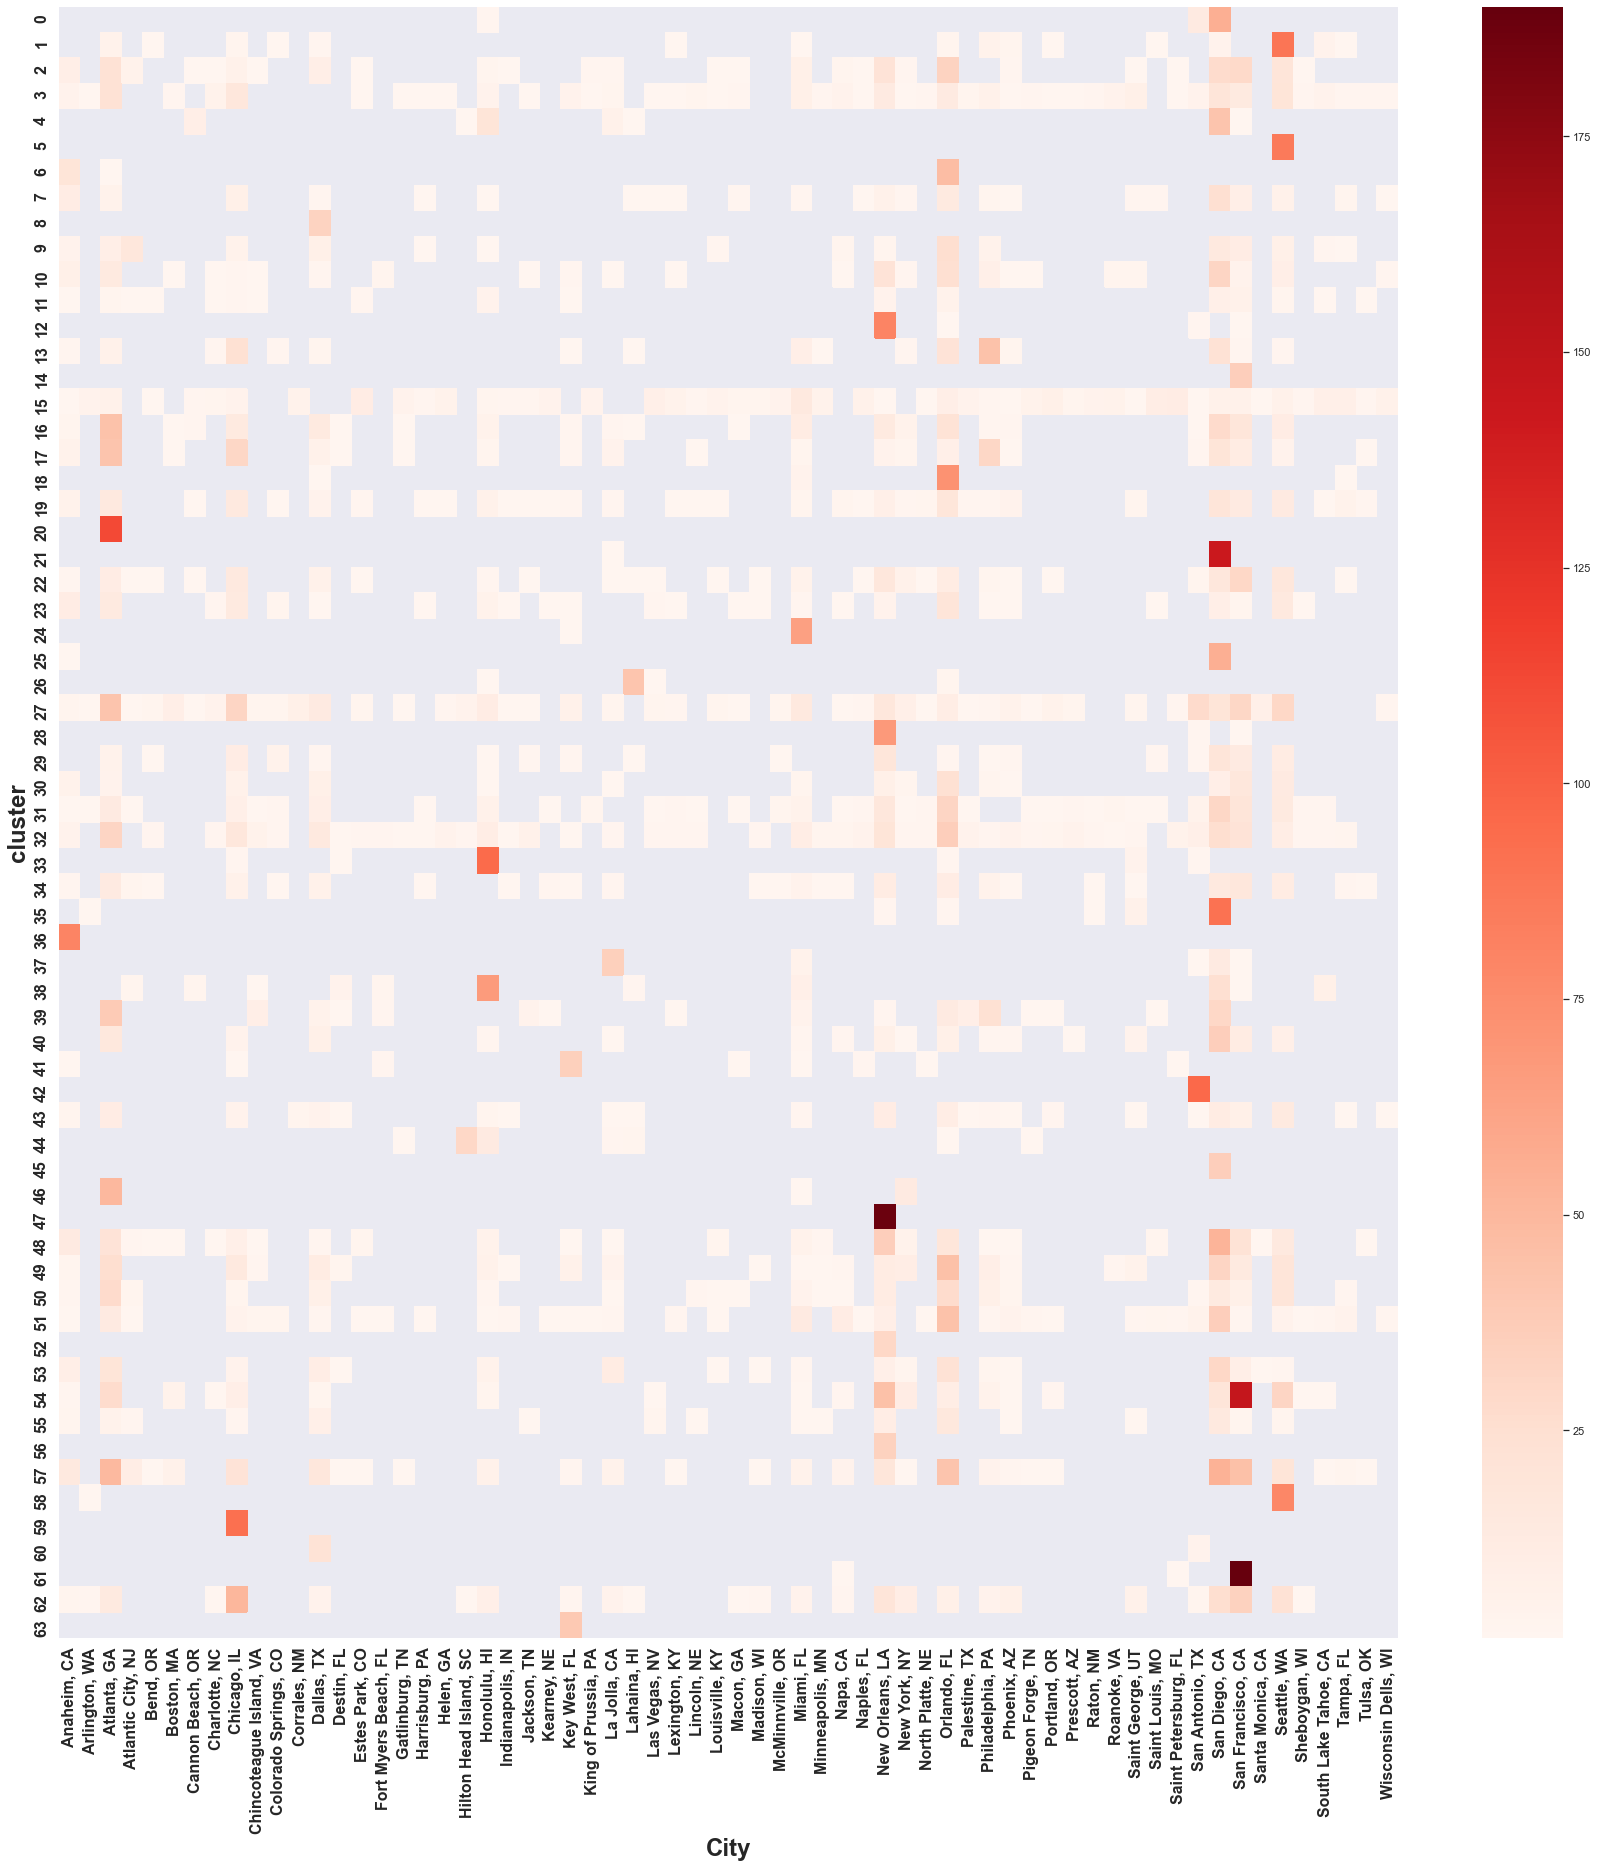

In [15]:
clusters = cutoff.groupby(['cluster', 'city_and_state']).size()
fig2, ax2 = plt.subplots(figsize = (30, 30))
sns.heatmap(clusters.unstack(level = 'city_and_state'), ax = ax2, cmap = 'Reds')

ax2.set_xlabel('City', fontdict = {'weight': 'bold', 'size': 24})
ax2.set_ylabel('cluster', fontdict = {'weight': 'bold', 'size': 24})
for label in ax2.get_xticklabels():
    label.set_size(16)
    label.set_weight("bold")
for label in ax2.get_yticklabels():
    label.set_size(16)
    label.set_weight("bold")
plt.savefig("001.png")